# Guassian Mixture Models

$$
p({\bf x}_i|\theta) = \sum_{k=1}^K \pi_k\mathcal{N}({\bf x}_i|\mu_k,\sigma_k)
$$

一种无监督聚类和密度估计的方法

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize, show_options

#用seaborn绘图
import seaborn as sns;
sns.set()

## 直观的拟合例子
应用sklearn求参数

(-10, 20)

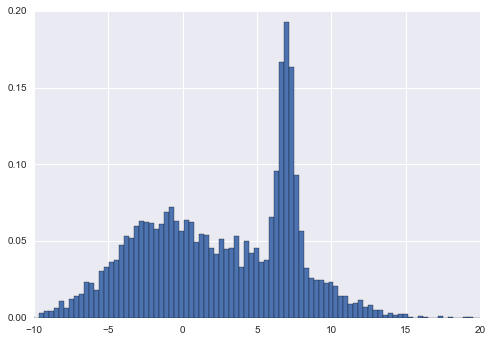

In [18]:
#数据
np.random.seed(2)
# x的数据随机来自于三个正太分布，均值和方差分别为(0,2);(5,5);(3,0.5)
x = np.concatenate([
        np.random.normal(-2,3,2000),
        np.random.normal(5,4,2000),
        np.random.normal(7,0.5,1000)])
plt.hist(x,100,normed=True)
plt.xlim(-10,20)

高斯混合模型用于该模型的密度估计，从上面的图可以看出，如果该分布不止一个峰，用单一的分布无法较好的揭示数据的特性

shape of X (5000, 1)


(-10, 20)

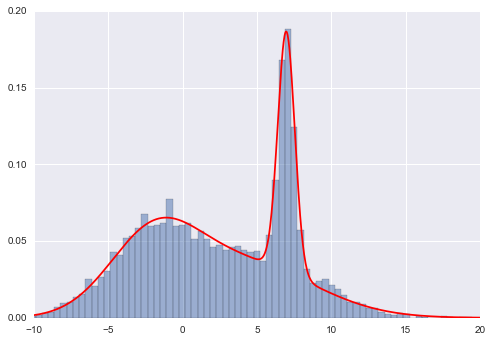

In [27]:
from sklearn.mixture import GMM
X = x[:,np.newaxis]
print("shape of X {}".format(X.shape))
clf = GMM(3,n_iter=500,random_state=3).fit(X)
xpdf = np.linspace(-10,20,1000)
density = np.exp(clf.score(xpdf[:,np.newaxis]))

plt.hist(x,80,normed=True,alpha=0.5)
plt.plot(xpdf,density,'-r')
plt.xlim(-10,20)

## 简单的两个一元混合高斯的例子

数据的构造：分布从两个一元高斯分布中抽样，组成两个样本s1,s2.
把两个样本连接，组成混合模型的样本s

/Users/igor/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/igor/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


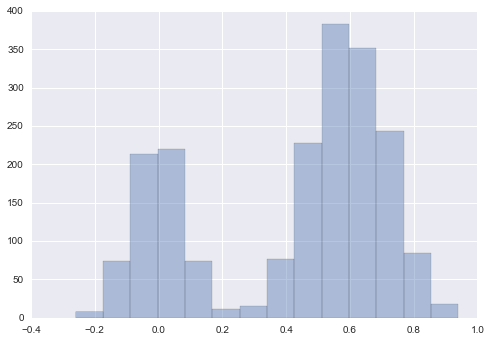

In [28]:
N = 2000
a = 0.3
# 分布的参数，均值和方差
mu1 = 0
sigma1 = 0.08
mu2 = 0.6
sigma2 = 0.12
s1 = np.random.normal(mu1,sigma1,size=N * a)
s2 = np.random.normal(mu2,sigma2,size=N * (1-a))
s = np.concatenate([s1,s2])

# hist plot
sns.distplot(s,kde=False)

混合高斯模型的PDF为：
$$
p(x|p) = \frac{\pi_1}{\sigma_1 \sqrt{2\pi}}exp \{-\frac{(x-\mu_1)^2}{2 \sigma_1^2} \} + \frac{\pi_2}{\sigma_2 \sqrt{2\pi}}exp \{-\frac{(x-\mu_2)^2}{2 \sigma_2^2} \}
$$
其中$p = [\mu_1,\sigma_1,\mu_2,\sigma_2,\pi_1]$,$\pi_2 = 1- \pi_1$

In [8]:
# 用numpy定义好的normpdf来生成混合模型的概率密度函数
def pdf_model(x,p):
    mu1, sig1, mu2, sig2, pi_1 =  p
    return pi_1*stats.norm.pdf(x,mu1,sig1) + (1-pi_1)*stats.norm.pdf(x,mu2,sig2)

## 最大似然估计：直接最大化
尝试利用最大似然估计的方法来直接进行参数估计，从理论上来说，该模型包含了缺失的数据和变量，因此直接使用
最大似然估计将会很困难，这里我们在程序上证明这种估计的困难

给定一个数据集s，写出似然函数：
$$
L(p) = \prod_i f(s_i|p)
$$
对数似然函数为：
$$
\ln L(p) = \sum_i \ln f(s_i | p)
$$

很明显的是，$f(s_i|p)$是两项算式的和，因此不能通过ln函数进行简化，我们在最优化的过程中需要计算指数和log运算，
在求导和计算过程都会显得非常复杂

In [37]:
# 定义对数似然函数
def log_likelihood_two_1d_gauss(p,sample):
    return -np.log(pdf_model(sample,p)).sum()

> Python NOTES:
Here we use the function minimize() from scipy.optimization. This function allows to choose several minimization methods. The list of (currently) available minimization methods is 'Nelder-Mead' (simplex), 'Powell', 'CG', 'BFGS', 'Newton-CG',> 'Anneal', 'L-BFGS-B' (like BFGS but bounded), 'TNC', 'COBYLA', 'SLSQPG'.
The documetation can be found [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

In [20]:
# 初始化参数
p0 = np.array([-0.2,0.2,0.2,0.8,0.5])

In [23]:
# 最优化 1
res = minimize(log_likelihood_two_1d_gauss,x0=p0,args=(s,),method='BFGS')
print(res)

      fun: nan
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([ nan,  nan,  nan,  nan,  nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 294
      nit: 1
     njev: 42
   status: 2
  success: False
        x: array([ 2192867.83125,   589607.575  ,   837275.0125 , -1512808.3875 ,
       -2336479.25   ])


In [25]:
# 最优化 2
res = minimize(log_likelihood_two_1d_gauss, x0=p0, args=(s,), method='powell',
        options=dict(maxiter=10e3, maxfev=2e4))
#res # NOT CONVERGED
res

   direc: array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])
     fun: nan
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 20009
     nit: 303
  status: 1
 success: False
       x: array([ nan,  nan,  nan,  nan,  nan])

In [27]:
# 最优化 3
res = minimize(log_likelihood_two_1d_gauss, x0=p0, args=(s,), method='Nelder-Mead',
        options=dict(maxiter=10e3, maxfev=2e4))
res

 final_simplex: (array([[ -1.06730224e+307,   1.03438031e+307,   1.94953533e-001,
          4.26220199e-001,  -5.80711194e+307],
       [ -1.06730224e+307,   1.03438031e+307,   1.94953533e-001,
          4.26220199e-001,  -5.80711194e+307],
       [ -1.06730224e+307,   1.03438031e+307,   1.94953533e-001,
          4.26220199e-001,  -5.80711194e+307],
       [ -1.06730224e+307,   1.03438031e+307,   1.94953533e-001,
          4.26220199e-001,  -5.80711194e+307],
       [ -1.06730224e+307,   1.03438031e+307,   1.94953533e-001,
          4.26220199e-001,  -5.80711194e+307],
       [ -1.06730224e+307,   1.03438031e+307,   1.94953533e-001,
          4.26220199e-001,  -5.80711194e+307]]), array([-1416415.89382344, -1416415.89382344, -1416415.89382344,
       -1416415.89382344, -1416415.89382344, -1416415.89382344]))
           fun: -1416415.8938234409
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 20006
           nit: 8706
        status: 1
      

In [38]:
# Minimization 4
res = minimize(log_likelihood_two_1d_gauss, x0=p0, args=(s,), method='L-BFGS-B',
    bounds=[(-0.5,2),(0.01,0.5),(-0.5,2),(0.01,0.5),(0.01,0.99)])
res

      fun: -494.5079199458761
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01159606,  0.04594654,  0.08969891,  0.00260911, -0.00605951])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 330
      nit: 31
   status: 0
  success: True
        x: array([ 0.5992644 ,  0.1162838 , -0.00278239,  0.07746054,  0.70105534])

## Expectation Maximization

在混合模型的情景下，我们假设的潜在变量是那个反应数据来自于哪个成分的变量。

\begin{align}
Q(\theta,\theta^{t-1})  & \triangleq {\Bbb E} \left[\sum_i\log p({\bf x}_i,{\bf z}_i| \theta)\right] \\
& = {\Bbb E}\left[\log \left[ \prod_{k=1}^K \pi_k p({\bf x}_i|\theta_k )^{{\Bbb I}(z_i=k)} \right]\right] \\
&= \sum_i\sum_k{\Bbb E}[{\Bbb I(z_i = k)}] log[\pi_kp({\bf x}_i|\theta_k )] \\
&= \sum_i\sum_kp(z_i=k|{\bf x}_i,\theta^{t-1}) log[\pi_kp({\bf x}_i|\theta_k )]  \\
&= \sum_i\sum_k r_{ik}\log\pi_k + \sum_i\sum_kr_{ik}\log p({\bf x}_i|\theta_k )
\end{align} 

其中$r_{ik} = p(z_i=k|{\bf x}_i,\theta^{t-1})$称为responsibility, 表示给定数据，数据来自于第k类的概率，
对于这个例子来说，每一个样本$s_i$,都会有两个系数，$r_{i1}$和$r_{i2}$,分别表示数据来自于成分1和2

单个成分的PDF分别为$f_1()$和$f_2()$：
$$
f_1(x|p) = \frac{1}{\sigma_1\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_1)^2}{2\sigma_1^2} \right\}
\qquad
f_2(x|p) = \frac{1}{\sigma_2\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_2)^2}{2\sigma_2^2} \right\}
$$
混合模型的PDF为：
$$
f(x|p) = \pi_1f_1(x|p) + \pi_2f_2(x|p)
$$
如果已知了一个参数p，则每个样本都可以计算出每个成分的responsibility function(E-step)
$$
r_{ik} = \frac{\pi_kf_k(s_i|p)}{f(s_i|p)}
$$
根据每个类样本“有效的”数量计算一个新的参数（M-step）：
$$
N_k = \sum^N_{i=1} r_{ik}\qquad\qquad
k=1,2
\quad
({\rm note\;that} \quad N_1 + N_2 = N)
$$
$$
\mu_k^{new} = \frac{1}{N_k} \sum_{i=1}^N r_{ik}*s_i \\
\sigma^{2 new}_k = \frac{1}{N_k}\sum^N_{i=1}r_{ik}*(s_i-mu_k^{new})^2
\pi_k^{new} = \frac{N_k}{N}
$$

循环：
1. 计算$r_{ik}$
2. 估计并更新参数

直到收敛


实现EM算法

In [31]:
max_iter = 100

#初始化参数
p0 = np.array([-0.2,0.2,0.8,0.2,0.5])
mu1,sig1,mu2,sig2,pi_1 = p0
mu = np.array([mu1,mu2])
sig = np.array([sig1,sig2])
pi_ = np.array([pi_1,1- pi_1])

r = np.zeros((2,s.size))
N_ = np.zeros(2)
p_new = p0

In [33]:
#EM loop
counter = 0
converged = False
while not converged:
    
    for k in [0,1]:
        # E-step,计算responsibility function
        r[k,:] = (pi_[k] * stats.norm.pdf(s,mu[k],sig[k])) / pdf_model(s,p_new)
        #M-step
        N_[k] = r[k].sum()
        mu[k] = sum(r[k]*s)/N_[k]
        sig[k]= np.sqrt(sum(r[k]*(s-mu[k])**2)/N_[k])
        pi_[k] = N_[k] / s.size
    p_new = [mu[0],sig[0],mu[1],sig[1],pi_[0]]
    assert abs(N_.sum() - N) / float(N) < 1e-6
    assert abs(pi_.sum() -1 ) < 1e-6
    
    counter += 1
    converged = counter >= max_iter

In [34]:
print("Means:   %6.3f  %6.3f" % (p_new[0], p_new[2]))
print("Std dev: %6.3f  %6.3f" % (p_new[1], p_new[3]))
print("Mix (1): %6.3f " % p_new[4])

Means:   -0.003   0.599
Std dev:  0.077   0.116
Mix (1):  0.299 


In [35]:
print(pi_.sum(),N_.sum())

1.0 2000.0


In [39]:
res.x

array([ 0.5992644 ,  0.1162838 , -0.00278239,  0.07746054,  0.70105534])

## 抛硬币的例子

有两枚硬币，随机的选择一枚硬币，然后抛十次，记录下正反的次数。
重复整个过程。

最大似然的结果：
![](http://oenpqslrk.bkt.clouddn.com/2016-10-07-20%3A23%3A24.jpg)


> 伯努利试验：扔一次硬币
> 二项分布：重复的伯努利试验
$$
p(k) =  \begin{pmatrix} n \\ k \end{pmatrix} p^k(1-p)^{n-k}
$$


In [16]:
# n = 10 固定，观察概率密度函数随着p的变化情况，假设p是一次伯努利试验，硬币是正面的概率
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib inline

In [30]:
a = range(11)
def plot_binomial(p=0.5):
    fig,ax = plt.subplots(figsize=(4,3))
    y = [0]*11
    for i in a:
        y[i-1] = stats.binom.pmf(i,10,p)
    ax.bar(a,y,label="$p = %.1f$"%p)
    ax.set_ylabel('PMF of $k$ heads')
    ax.set_xlabel("$k$")
    ax.set_ylim((0,0.5))
    ax.set_xlim((0,10))
    ax.legend()
    return

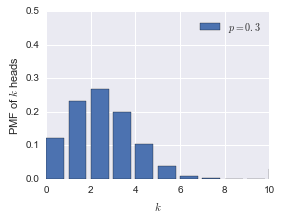

In [31]:
interact(plot_binomial,p=widgets.FloatSlider(min=0.0,max=1.0,step=0.1))

已知最大似然的解(通过似然函数求偏导而得)：
$$
p_{ML} = \frac {count}{n} \\
p(A = head|D) = \frac {heads\ observed\ when\ A\ was\ thrown}{times\ A\ was\ thrown}
$$

### 完全观测到数据的例子
如果我们能过观测到所有数据，知道每一次扔的时候所使用的是哪一枚硬币，
则这个问题可以简化到最大似然。通常情况下用的哪一枚硬币是隐藏变量，
不能被观测到

In [34]:
# A硬币扔的情况
observations_A = np.array([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1]])

In [35]:
# 抛硬币A正面的数量为
np.sum(observations_A)

24

In [36]:
# 给定A为正面的条件概率$p(head|A)$为
1.0 * np.sum(observations_A)/observations_A.size

0.80000000000000004

### EM算法的过程-包含隐藏变量的设定
这个时候我不知道到底是哪一枚硬币被用来扔，这能观测到每次抛掷的结果

EM算法的过程：
![](http://oenpqslrk.bkt.clouddn.com/2016-10-07-20%3A26%3A56.jpg)

### Step 0: 初始化参数
$$
\theta_A^0 = 0.6 \\
\theta_B^0 = 0.5
$$
### Step2: E-step
结果是：HTTTHHTHTH,表示有5次正面，5次反面


In [37]:
# 计算A的pmf
coin_A_pmf_observation_1 = stats.binom.pmf(5,10,0.6)
coin_A_pmf_observation_1

0.20065812480000034

In [39]:
# 类似的我们获得B
coin_B_pmf_observation_1 = stats.binom.pmf(5,10,0.5)
coin_B_pmf_observation_1

0.24609375000000025

由于B的pmf比A的pmf更大，因此可以说明B更有可能扔出这样的结果
接下来归一化，然后用于加权我们的观测值

In [40]:
normalized_coin_A_pmf_observation_1 = coin_A_pmf_observation_1 / (coin_A_pmf_observation_1 + coin_B_pmf_observation_1)
print("%.2f"%normalized_coin_A_pmf_observation_1)
normalized_coin_B_pmf_observation_1= coin_B_pmf_observation_1 / (coin_A_pmf_observation_1+coin_B_pmf_observation_1)
print("%.2f"%normalized_coin_B_pmf_observation_1)

0.45
0.55


In [41]:
weighted_heads_A_obervation_1 = 5*normalized_coin_A_pmf_observation_1
print("Coin A Weighted count for heads in observation 1: %0.2f" %weighted_heads_A_obervation_1)
weighted_tails_A_obervation_1 = 5*normalized_coin_A_pmf_observation_1
print("Coin A Weighted count for tails in observation 1: %0.2f" %weighted_tails_A_obervation_1)
weighted_heads_B_obervation_1 = 5*normalized_coin_B_pmf_observation_1
print("Coin B Weighted count for heads in observation 1: %0.2f" %weighted_heads_B_obervation_1)
weighted_tails_B_obervation_1 = 5*normalized_coin_B_pmf_observation_1
print("Coin B Weighted count for tails in observation 1: %0.2f" %weighted_tails_B_obervation_1)


Coin A Weighted count for heads in observation 1: 2.25
Coin A Weighted count for tails in observation 1: 2.25
Coin B Weighted count for heads in observation 1: 2.75
Coin B Weighted count for tails in observation 1: 2.75


整个过程我们获得了加权计数,注意计算的过程等价于在求均值，概率*取值
### Step 2: M-step
一次迭代后，加权计数表明，如果用硬币A，我们会得到21.3次正面，8.6次反面，在此时执行一次最大似然估计，
用于更新参数

In [44]:
21.3 /(21.3+8.6)

0.7123745819397994

### EM 单次迭代

In [58]:
def em_single(priors,observations):
    '''
    执行单次的EM步骤
    ---
    priors:[theta_A,theta_B]
    observations:[m X n matrix]
    ---
    
    return:
    ---
    new_priors:[new_theta_A,new_theta_B]
    ---
    '''
    counts = {'A':{'H':0,'T':0},'B':{'H':0,'T':0}}
    theta_A = priors[0]
    theta_B = priors[1]
    # E step
    for observation in observations:
        len_observation = len(observation)
        num_heads=observation.sum()
        num_tails=len_observation - num_heads
        contribution_A = stats.binom.pmf(num_heads,len_observation,theta_A)
        contribution_B = stats.binom.pmf(num_heads,len_observation,theta_B)
        weight_A = contribution_A / (contribution_A + contribution_B)
        weight_B = contribution_B / (contribution_A + contribution_B)
        # Incrementing counts
        counts['A']['H'] += weight_A * num_heads
        counts['A']['T'] += weight_A * num_tails
        counts['B']['H'] += weight_B * num_heads
        counts['B']['T'] += weight_B * num_tails
    # M step

    new_theta_A = counts['A']['H'] / (counts['A']['H'] + counts['A']['T'])
    new_theta_B = counts['B']['H'] / (counts['B']['H'] + counts['B']['T'])
    return [new_theta_A,new_theta_B]

###  EM procedure
不断的调用single EM 迭代过程，制止收敛或者停止条件
- 1000 iterations
- prior的改变小于1e-6

In [60]:
def em(observations,prior,tol=1e-6,iterations=1000):
    iteration = 0
    while iteration < iterations:
        new_prior = em_single(prior,observations)
        delta_change = np.abs(prior[0] - new_prior[0])
        if delta_change < tol :
            break
        else:
            prior = new_prior
            iteration += 1
    return [new_prior,iteration]

In [61]:
observations = np.array([[1,0,0,0,1,1,0,1,0,1],
                         [1,1,1,1,0,1,1,1,1,1],
                         [1,0,1,1,1,1,1,0,1,1],
                         [1,0,1,0,0,0,1,1,0,0],
                         [0,1,1,1,0,1,1,1,0,1]])

In [62]:
em(observations,[0.6,0.5])

[[0.79678875938310978, 0.51958393567528027], 14]

In [63]:
em(observations,[0.3,0.5])

[[0.51958079092227893, 0.79674072974447407], 8]